In [1]:
import logging
import copy
import os
import sys
from functools import reduce
from collections import Counter

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, cross_validate
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src import TEST_APPENDIX
from src import sb12_train_data_path, sb12_test_data_path
from src.preprocess.dep_parse import load_parsed_reviews
from src import parsed_reviews_dump_path
from src.utils.embedding import get_embeddings
from src.target.target_classifier import TargetClassifier
from src.score import print_sb12, print_sb1, print_sb2

import warnings
warnings.filterwarnings("ignore", category=UserWarning) 
logging.basicConfig(level=logging.INFO)

seed = 42
np.random.seed(seed)

ModuleNotFoundError: No module named 'src.score'

# Upload

In [2]:
word2vec = get_embeddings()

INFO:gensim.models.utils_any2vec:loading projection weights from /home/dmitry/Projects/diploma/research/RusVectores/tayga_upos_skipgram_300_2_2019/model.bin
INFO:gensim.models.utils_any2vec:loaded (249565, 300) matrix from /home/dmitry/Projects/diploma/research/RusVectores/tayga_upos_skipgram_300_2_2019/model.bin


### train

In [3]:
train_parsed_reviews = load_parsed_reviews(file_pathway=parsed_reviews_dump_path)
train_sentences = [
    x for x in reduce(lambda x, y: x + y, train_parsed_reviews)
]

INFO:root:Mon Apr 20 21:29:39 2020. Upload dependency trees from dump.


### test

In [4]:
test_parsed_reviews = load_parsed_reviews(
    file_pathway=parsed_reviews_dump_path + TEST_APPENDIX)
test_sentences = [
    x for x in reduce(lambda x, y: x + y, test_parsed_reviews)
]

INFO:root:Mon Apr 20 21:29:40 2020. Upload dependency trees from dump.


# Preprocess

Create dataframe from train senetences

In [5]:
if True:
    train_df, train_y = TargetClassifier._load_data()
else:
    train_df, train_y = TargetClassifier(word2vec=word2vec)._get_df(sentences=train_sentences)
    TargetClassifier._dump_data(df=train_df, y=train_y)

# Classifiers

## Random forest

In [7]:
parameters = {
    'n_estimators': 900,
    'max_features': 0.326,
    'min_samples_leaf': 2,
    'max_depth': None,
    'random_state': seed,
    'n_jobs': -1,
    'bootstrap': True, 
    'oob_score': True
}
classifier_class=RandomForestClassifier

### n_estimators

100%|██████████| 14/14 [02:23<00:00, 10.23s/it]
n_estimators: 1200 
Accuracy: 0.929


(1200, 0.9293132965569717)

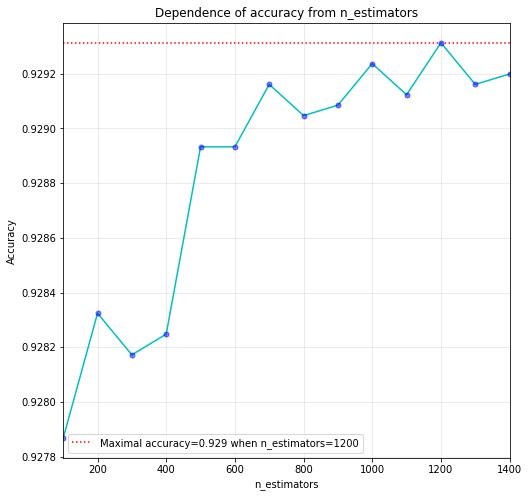

In [40]:
parameter_vals = [x for x in range(100, 2000, 50)]
analyse_parameter(classifier_class=classifier_class,
                  fixed_parameters=parameters,
                  df=train_df,
                  y=train_y,
                  parameter='n_estimators', 
                  parameter_vals=parameter_vals)

### max_features

Число признаков для выбора расщепления

100%|██████████| 20/20 [13:22<00:00, 40.14s/it]
max_features: 0.3263157894736842 
Accuracy: 0.931


(0.3263157894736842, 0.9311013886246909)

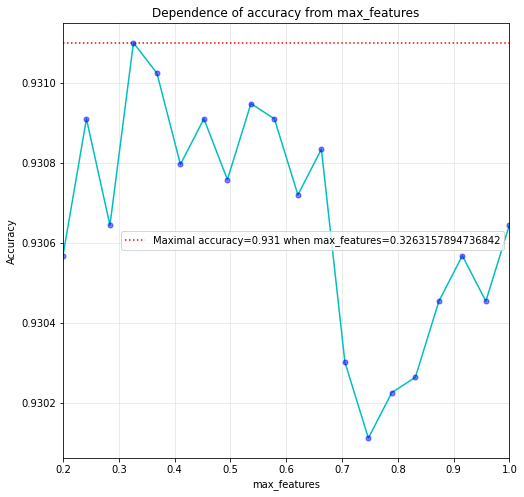

In [13]:
parameter_vals = [x for x in np.linspace(0.2, 1.0, 20)]
analyse_parameter(classifier_class=classifier_class,
                  fixed_parameters=parameters,
                  df=train_df,
                  y=train_y,
                  parameter='max_features', 
                  parameter_vals=parameter_vals)

### min_samples_leaf

Ограничение на число объектов в листьях

min_samples_leaf: 2 
Accuracy: 0.929


(2, 0.9290850294844969)

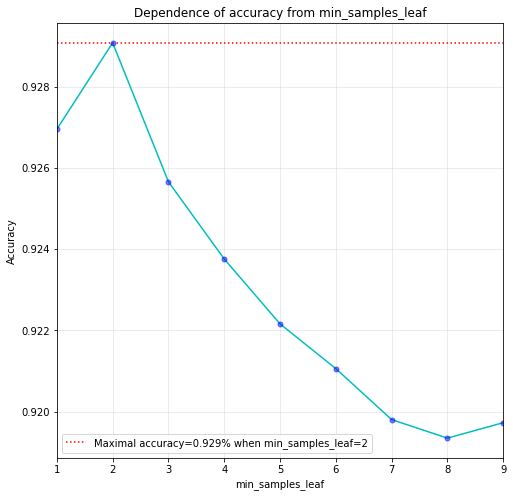

In [31]:
parameter_vals = [x for x in range(1, 10)]
analyse_parameter(classifier_class=classifier_class,
                  fixed_parameters=parameters,
                  df=train_df,
                  y=train_y,
                  parameter='min_samples_leaf', 
                  parameter_vals=parameter_vals)

### max_depth

Максимальная глубина дерева

100%|██████████| 10/10 [01:58<00:00, 11.80s/it]
max_depth: 29 
Accuracy: 0.929


(29, 0.9289708959482594)

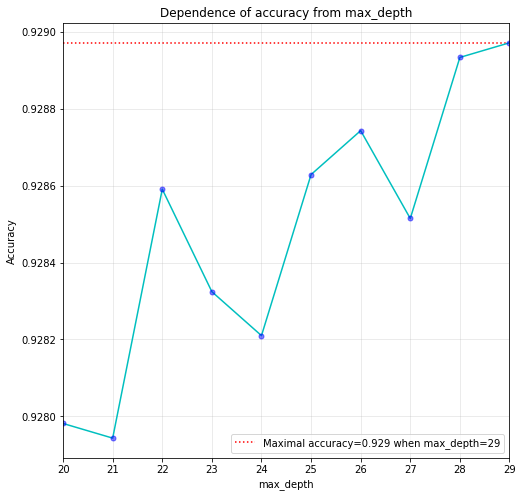

In [37]:
parameter_vals = [x for x in range(10, 50)]
analyse_parameter(classifier_class=classifier_class,
                  fixed_parameters=parameters,
                  df=train_df,
                  y=train_y,
                  parameter='max_depth', 
                  parameter_vals=parameter_vals)

### Test

In [8]:
sentences_pred = copy.deepcopy(test_sentences)

In [ ]:
classifier = classifier_class(**parameters)
target_classifier = TargetClassifier(classifier=classifier,
                                     word2vec=word2vec)
target_classifier.fit(df=train_df, y=train_y)
sentences_pred = target_classifier.predict(sentences_pred)

In [10]:
print_sb12(sentences=test_sentences, 
           sentences_pred=sentences_pred)

Precision: 0.37615
Recall: 0.53560
F1: 0.44193


In [11]:
print_sb1(sentences=test_sentences, 
          sentences_pred=sentences_pred)

Precision: 0.46846
Recall: 0.78538
F1: 0.58687


### results

In [25]:
s = slice(0, 10)
for sentence, sentence_pred in zip(test_sentences[s], sentences_pred[s]):
    sentence.to_sentence().get_normalized().display()
    print()
    sentence_pred.to_sentence().get_normalized().display()
    print('-'*100)

очень милый , уютный ресторанчик со скромными ценами за огромные порции вкуснейших блюд .
очень милый , уютный ресторанчик со скромными ценами за огромные порции вкуснейших блюд .----------------------------------------------------------------------------------------------------
мы отмечали день рождения , нам разрешили принести свой тортик со свечками .
мы отмечали день рождения , нам разрешили принести свой тортик со свечками .----------------------------------------------------------------------------------------------------
салаты со свежайшей зеленью , мясо и курица нежные , а десерт , в частности семифреддо миндальный - это что-то сказочно вкусное .
салаты со свежайшей зеленью , мясо и курица нежные , а десерт , в частности семифреддо миндальный - это что-то сказочно вкусное .----------------------------------------------------------------------------------------------------
официантки вежливые и улыбчивые .
официантки вежливые и улыбчивые .---------------------------------------

## gradient boosting

In [7]:
parameters = {
    'learning_rate': 0.1,
    'n_estimators': 900,
    'min_samples_leaf': 2,
    'random_state': seed,
}
classifier_class = GradientBoostingClassifier

### n_estimators

In [8]:
parameter_vals = [x for x in range(100, 1500, 100)]
analyse_parameter(classifier_class=classifier_class,
                  fixed_parameters=parameters,
                  df=train_df,
                  y=train_y,
                  parameter='n_estimators', 
                  parameter_vals=parameter_vals,
                  is_oob_score=False)

  0%|          | 0/14 [00:59<?, ?it/s]


TypeError: Cannot clone object '<src.target.target_classifier.TargetClassifier object at 0x7f997ce4f190>' (type <class 'src.target.target_classifier.TargetClassifier'>): it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' methods.

### learning_rate

In [ ]:
parameter_vals = [x for x in np.linspace(0.05, 0.5, 10)]
analyse_parameter(classifier_class=classifier_class,
                  fixed_parameters=parameters,
                  df=train_df,
                  y=train_y,
                  parameter='learning_rate', 
                  parameter_vals=parameter_vals)

### max_features

In [ ]:
parameter_vals = [x for x in np.linspace(0.2, 1.0, 20)]
analyse_parameter(classifier_class=classifier_class,
                  fixed_parameters=parameters,
                  df=train_df,
                  y=train_y,
                  parameter='max_features', 
                  parameter_vals=parameter_vals)

### min_samples_leaf

In [ ]:
parameter_vals = [x for x in range(1, 10)]
analyse_parameter(classifier_class=classifier_class,
                  fixed_parameters=parameters,
                  df=train_df,
                  y=train_y,
                  parameter='min_samples_leaf', 
                  parameter_vals=parameter_vals)

### Test

In [ ]:
classifier = classifier_class(**parameters)
target_classifier = TargetClassifier(classifier=classifier,
                                     word2vec=word2vec)
target_classifier.fit(df=train_df, y=train_y)
target_classifier.predict(test_sentences)